In [1]:
#importing python libs

import sympy as sym
sym.init_printing()

import numpy as np
from math import pi
import math
import matplotlib.pyplot as plt
from sympy import I, Matrix, symbols
from sympy.physics.quantum import TensorProduct, Dagger
import scipy.optimize
import scipy.integrate
import scipy.constants as const

#import qutip

from matplotlib.colors import Normalize as Norm

%load_ext cython
import time

In [2]:
#from sympy.physics.quantum import Commutator as comm
def comm(A,B):
    return A*B-B*A

In [3]:
#define some s pre/post operators

def spre(m):
    return TensorProduct(sym.eye(m.shape[0]),m)

def spost(m):
    return TensorProduct(m.T, sym.eye(m.shape[0]))

def collapse(c):
    tmp = Dagger(c)*c/2
    return spre(c)*spost(Dagger(c))-spre(tmp)-spost(tmp)


s13=Matrix([[0,0,1],[0,0,0],[0,0,0]])
s23=Matrix([[0,0,0],[0,0,1],[0,0,0]])
s12=Matrix([[0,1,0],[0,0,0],[0,0,0]])

s31=s13.T
s32=s23.T
s21=s12.T

s11 = s12*s21
s22 = s21*s12
s33 = s31*s13

In [4]:
delo,delm=sym.symbols('delta_o delta_mu', real=True) 
#delao, delam =sym.symbols('delta_a_o delta_a_mu') #detunings between atom and cavity
gamma13,gamma23,gamma2d,gamma3d,nbath,gammamu=sym.symbols('gamma_13 gamma_23 gamma_2d gamma_3d n_b gamma_mu', real=True, negative=False) #energy decay for atom levels
Omega=sym.symbols('Omega', real=False) #pump Rabi frequency
rho11, rho12, rho13, rho21, rho22, rho23, rho31, rho32, rho33=sym.symbols('rho_11 rho_12 rho_13 rho_21 rho_22 rho_23 rho_31 rho_32 rho_33') #Density matrix elements
a, b = sym.symbols('a b') #classical amplitudes of the optical and microwave fields
#ar,ai=sym.symbols('a_r a_i', real=True)
go, gm=sym.symbols('g_o, g_mu',real=False) #coupling strengths for optical and microwave fields
lam=sym.symbols('lambda')
Del= sym.symbols('Delta', real=True)
Gam=sym.symbols('Gamma', real=True, postive=True)
Wsq=sym.symbols('Omega_sq', real=True, positive=True)

In [5]:
p = {}

p['deltamu'] = 0.
p['deltao'] = 0.


p['d13'] = 2e-32*math.sqrt(1/3)
p['d23'] = 2e-32*math.sqrt(2/3)
p['gamma13'] = p['d13']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma23'] = p['d23']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma2d'] = 1e6
p['gamma3d'] = 1e6
p['nbath'] = 20
p['gammamu'] = 1/(p['nbath']+1) * 1e3

p['go'] = 51.9  #optical coupling

p['No'] = 1.28e15 # number of atoms in the optical mode

p['deltac']=0 #detuning for 
p['kappaoi']=2*pi*7.95e6 # intrinsic loss for optical resonator
p['kappaoc']=2*pi*1.7e6 # coupling loss for optical resonator
#p['df']=0.1e6 # how small descretisation step to take when integrating over the 
            # inhomogeneous lines

p['mean_delam']=0
p['sd_delam']=2*pi*25e6/2.355  #microwave inhomogeneous broadening
                                #2.355is to turn FWHM into standard deviation
p['mean_delao']=0
p['sd_delao']=2*pi*170e6/2.355 #optical inhomogeneous broadening

p['kappami'] = 650e3*2*pi # intrinsic loss for microwave cavity
p['kappamc'] = 70e3*2*pi  # coupling loss for optical cavity
                        # this is for one of the two output ports
p['Nm'] = 2.22e16  #toal number of atoms
p['gm'] = 1.04 #coupling between atoms and microwave field

p['gammaoc']=2*pi*1.7e6
p['gammaoi']=2*pi*7.95e6
p['gammamc']=2*pi*70e3
p['gammami']=2*pi*650e3


muBohr=927.4009994e-26; # Bohr magneton in J/T in J* T^-1
p['mu12'] = 4.3803*muBohr # transition dipole moment for microwave cavity (J T^-1)

p['Lsample']=12e-3 # the length of the sample, in m
p['dsample']=5e-3 # the diameter of the sample, in m

p['fillfactor']=0.8 #microwave filling factor
p['freqmu'] = 5.186e9
p['freq_pump'] = 195113.36e9 #pump frequency
p['freqo']=p['freqmu']+p['freq_pump']

p['Lcavity_vac'] = 49.5e-3 # length of the vacuum part of the optical
                           # Fabry Perot (m)
p['Wcavity'] =  0.6e-3# width of optical resonator beam in sample (m)
p['nYSO'] = 1.76
p['Omega']=-492090.88755145477



In [6]:
def singular_test_bad(A):
    A_func=sym.lambdify((delo,delm,gamma13,gamma23,gamma2d,gamma3d,nbath,gammamu,Omega,go, gm,a,b),A)
    A_det=np.zeros(10,dtype=np.complex_)
    for ii in range(10):
        A_mat=A_func(np.random.randn()*1e6,np.random.rand()*1e6,np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand(),np.random.rand())
        A_det[ii]=np.linalg.det(A_mat)
    if sum(A_det)==0:
        rval=0
    else:
        rval=A_det
    return rval

In [7]:
H=Omega*s32+gm*s21*b+go*s31*a
H=H+Dagger(H)
H=H+(delo)*s33+(delm)*s22

In [8]:
LH=-I*spre(H)+I*spost(H)
L21 = gammamu*(nbath+1)*collapse(s12)
L12 = gammamu*nbath*collapse(s21)
L32 = gamma23*collapse(s23)
L31 = gamma13*collapse(s13)
L22 = gamma2d*collapse(s22)
L33 = gamma3d*collapse(s33)

L=LH + L21 + L12 + L32 + L31 + L22 + L33
#L = L.row_insert(0,Matrix([[1,0,0,0,1,0,0,0,1]]))
#LH = LH.row_insert(0,Matrix([[1,0,0,0,1,0,0,0,1]]))

#L.row_del(1)

#define the density matrix in square and row form
#the row form is so the Liovillian in matrix form can be acted on it
rho = Matrix([[rho11,rho21,rho31],[rho12,rho22,rho32],[rho13,rho23,rho33]])
rho = 1*rho.T #because we are using "fortran" style matrix flatteneing
rho[:]
rhoflat = 1*rho.T 
rhoflat = rhoflat[:]

In [9]:
L0=L.subs({a:0,b:0})
La=L.subs({a:1,b:0})-L0
Lb=L.subs({a:0,b:1})-L0
LGamma=L-LH

In [10]:
H0=H.subs({a:0,b:0})
Ha=H.subs({a:1,b:0})-H0
Hb=H.subs({a:0,b:1})-H0
H1=a*Ha+b*Hb

In [11]:
La

⎡                __                                     ⎤
⎢  0     0    -ⅈ⋅gₒ    0    0    0    ⅈ⋅gₒ    0      0  ⎥
⎢                                                       ⎥
⎢  0     0      0      0    0    0      0    ⅈ⋅gₒ    0  ⎥
⎢                                                       ⎥
⎢-ⅈ⋅gₒ   0      0      0    0    0      0     0    ⅈ⋅gₒ ⎥
⎢                                                       ⎥
⎢                                 __                    ⎥
⎢  0     0      0      0    0  -ⅈ⋅gₒ    0     0      0  ⎥
⎢                                                       ⎥
⎢  0     0      0      0    0    0      0     0      0  ⎥
⎢                                                       ⎥
⎢  0     0      0    -ⅈ⋅gₒ  0    0      0     0      0  ⎥
⎢                                                       ⎥
⎢  __                                                 __⎥
⎢ⅈ⋅gₒ    0      0      0    0    0      0     0    -ⅈ⋅gₒ⎥
⎢                                                       ⎥
⎢         __  

In [12]:
Lb

⎡           ___                                                 ⎤
⎢  0     -ⅈ⋅gₘᵤ    0    ⅈ⋅gₘᵤ     0       0      0       0     0⎥
⎢                                                               ⎥
⎢-ⅈ⋅gₘᵤ    0       0      0     ⅈ⋅gₘᵤ     0      0       0     0⎥
⎢                                                               ⎥
⎢  0       0       0      0       0     ⅈ⋅gₘᵤ    0       0     0⎥
⎢                                                               ⎥
⎢  ___                             ___                          ⎥
⎢ⅈ⋅gₘᵤ     0       0      0     -ⅈ⋅gₘᵤ    0      0       0     0⎥
⎢                                                               ⎥
⎢          ___                                                  ⎥
⎢  0     ⅈ⋅gₘᵤ     0    -ⅈ⋅gₘᵤ    0       0      0       0     0⎥
⎢                                                               ⎥
⎢                  ___                                          ⎥
⎢  0       0     ⅈ⋅gₘᵤ    0       0       0      0       0     0⎥
⎢         

In [13]:
L0

⎡-γₘᵤ⋅n_b                     0                                     0         
⎢                                                                             
⎢                   γ_2d   γₘᵤ⋅n_b   γₘᵤ⋅(n_b + 1)                    _       
⎢   0      -ⅈ⋅δₘᵤ - ──── - ─────── - ─────────────                 -ⅈ⋅Ω       
⎢                    2        2            2                                  
⎢                                                                             
⎢                                                           γ₁₃   γ₂₃   γ_3d  
⎢   0                       -ⅈ⋅Ω                    -ⅈ⋅δₒ - ─── - ─── - ──── -
⎢                                                            2     2     2    
⎢                                                                             
⎢                                                                             
⎢   0                         0                                     0         
⎢                                                   

In [14]:
LGamma

⎡-γₘᵤ⋅n_b                 0                               0                   
⎢                                                                             
⎢            γ_2d   γₘᵤ⋅n_b   γₘᵤ⋅(n_b + 1)                                   
⎢   0      - ──── - ─────── - ─────────────               0                   
⎢             2        2            2                                         
⎢                                                                             
⎢                                              γ₁₃   γ₂₃   γ_3d   γₘᵤ⋅n_b     
⎢   0                     0                  - ─── - ─── - ──── - ───────     
⎢                                               2     2     2        2        
⎢                                                                             
⎢                                                                            γ
⎢   0                     0                               0                - ─
⎢                                                   

In [15]:
L0_fun=sym.lambdify((delo,delm,gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,Omega,go,gm),L0)
La_fun=sym.lambdify((go,gm),La)
Lb_fun=sym.lambdify((go,gm),Lb)
LGamma_fun=sym.lambdify((gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,Omega,go,gm),LGamma)

In [16]:
def rho0_fun(deloval,delmval,p):
    L0_mat=L0_fun(deloval,delmval,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['Omega'],p['go'],p['gm'])
    L0_mat[0,:]=np.array([[1,0,0,0,1,0,0,0,1]])
    rho = np.linalg.solve(L0_mat.astype('complex128'),np.matrix([[1,0,0,0,0,0,0,0,0]]).T)
    return rho#np.reshape(rho,(3,3),order='F')

In [17]:
def rhoa_fun(deloval,delmval,rho0,p):
    L0_mat=L0_fun(deloval,delmval,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['Omega'],p['go'],p['gm'])
    La_mat=La_fun(p['go'],p['gm'])
    return -np.matrix(np.linalg.inv(L0_mat))*np.matrix(La_mat)*np.matrix(rho0)#p.matrix(np.reshape(rho0,(9,1)))

In [18]:
def rhob_fun(deloval,delmval,rho0,p):
    L0_mat=L0_fun(deloval,delmval,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['Omega'],p['go'],p['gm'])
    Lb_mat=Lb_fun(p['go'],p['gm'])
    return -np.matrix(np.linalg.inv(L0_mat))*np.matrix(Lb_mat)*np.matrix(rho0)#p.matrix(np.reshape(rho0,(9,1)))

In [19]:
rho_0u=sym.simplify(L0.nullspace()[0]).subs({2*I*delo:2*I*delm+2*I*Del})
rho_0norm=((rho_0u)/(rho_0u[0]+rho_0u[4]+rho_0u[8]))
rho_0norm_lam1=sym.lambdify((Del, gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,Omega),rho_0norm)
def rho_0norm_lam(Del, gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,Omega):
    return np.stack(rho_0norm_lam1(Del, gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,Omega))[:,0]


In [20]:
rho_0norm

⎡                                                                             
⎢                                                                             
⎢─────────────────────────────────────────────────────────────────────────────
⎢            ⎛                                                                
⎢            ⎜    - (γ₁₃ + γ₂₃)⋅(2⋅ⅈ⋅Δ + γ₁₃ + γ₂₃ + γ_2d + γ_3d + γₘᵤ⋅(n_b + 
⎢4⋅Ω⋅γₘᵤ⋅n_b⋅⎜1 + ────────────────────────────────────────────────────────────
⎢            ⎜                                                                
⎢            ⎝                                                                
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [21]:
def rho0_GHint(p,deg=90):
    GHx,GHweights=np.polynomial.hermite.hermgauss(deg)
    rho0_GHfun=lambda x:(rho_0norm_lam(np.sqrt(2)*x*np.sqrt(p['sd_delam']**2+p['sd_delao']**2)
 +(p['mean_delao']-p['mean_delam']),p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'],p['nbath'],p['gammamu'],p['Omega']))/np.sqrt(np.pi)
    rho0_x=np.zeros((deg,9),dtype=np.complex_)
    for ii in [0, 4, 5, 7, 8]:

        rho0_x[:,ii]=rho0_GHfun(GHx)[ii]
    #print(rho0_x[])
    #print(GHx.shape)
    return np.matmul(GHweights[None,:],rho0_x)
    

In [ ]:
def rho0_GHint(Del, p,deg=90):
    GHx,GHweights=np.polynomial.hermite.hermgauss(deg)
    rho0_GHfun=lambda x:(rho_0norm_lam(np.sqrt(2)*x*np.sqrt(p['sd_delam']**2+p['sd_delao']**2)
 +(p['mean_delao']-p['mean_delam']),p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'],p['nbath'],p['gammamu'],p['Omega']))/np.sqrt(np.pi)
    rho0_x=np.zeros((deg,9),dtype=np.complex_)
    for ii in [0, 4, 5, 7, 8]:

        rho0_x[:,ii]=rho0_GHfun(GHx)[ii]
    #print(rho0_x[])
    #print(GHx.shape)
    return np.matmul(GHweights[None,:],rho0_x)
    

In [22]:
def rho0_integrate(p):
    muD=p['mean_delao']-p['mean_delam']
    sdD=np.sqrt(p['sd_delam']**2+p['sd_delao']**2)
    rho_0norm_fun=lambda Delvals: rho_0norm_lam(Delvals,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'],p['nbath'],p['gammamu'],p['Omega'])
    func_to_int=lambda Delvals:1/np.sqrt(2*np.pi)/sdD*np.exp(-(Delvals-muD)**2/(2*sdD**2))*rho_0norm_fun(Delvals)
    rho0_int=np.zeros(9,dtype=np.complex_)
    print('     ' + str(func_to_int(10.9).shape))
    #rho0_int=scipy.integrate.quad(func_to_int,-np.inf,np.inf)
    for ii in range(9):#[0, 4, 5, 7, 8]:
        Rfun=lambda Delvals: func_to_int(Delvals)[ii].real
        Ifun=lambda Delvals: func_to_int(Delvals)[ii].imag
        rho0_int[ii]=scipy.integrate.quad(Rfun,-np.inf,np.inf,limit=10000)[0]+1j*scipy.integrate.quad(Ifun,-np.inf,np.inf,limit=10000)[0]
    return rho0_int

In [78]:
def rho0_integrate(Del, p):
    muD=p['mean_delao']-p['mean_delam']
    sdD=np.sqrt(p['sd_delam']**2+p['sd_delao']**2)
    rho_0norm_fun=lambda Delvals: rho_0norm_lam(Delvals,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'],p['nbath'],p['gammamu'],p['Omega'])
    func_to_int=lambda Delvals:1/np.sqrt(2*np.pi)/sdD*np.exp(-(Delvals-Del-muD)**2/(2*sdD**2))*rho_0norm_fun(Delvals-Del)
    rho0_int=np.zeros(9,dtype=np.complex_)
    print('     ' + str(func_to_int(10.9).shape))
    #rho0_int=scipy.integrate.quad(func_to_int,-np.inf,np.inf)
    for ii in range(9):#[0, 4, 5, 7, 8]:
        Rfun=lambda Delvals: func_to_int(Delvals)[ii].real
        Ifun=lambda Delvals: func_to_int(Delvals)[ii].imag
        rho0_int[ii]=scipy.integrate.quad(Rfun,-np.inf,np.inf,limit=10000)[0]+1j*scipy.integrate.quad(Ifun,-np.inf,np.inf,limit=10000)[0]
    return rho0_int

In [23]:
def rho0_integrate_2d(delo,delm,p):
    rho_0norm_fun=lambda delovals,delmvals: rho_0norm_lam(delovals-delmvals,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'],p['nbath'],p['gammamu'],p['Omega'])
    func_to_int=lambda delovals,delmvals:1/(2*np.pi)/p['sd_delao']/p['sd_delam']*np.exp(-(delovals-delo-p['mean_delao'])**2/(2*p['sd_delao']**2))*np.exp(-(delmvals-delm-p['mean_delam'])**2/(2*p['sd_delam']**2))*rho_0norm_fun(delovals,delmvals)
    rho0_int=np.zeros(9,dtype=np.complex_)
    #rho0_int=scipy.integrate.quad(func_to_int,-np.inf,np.inf)
    for ii in [0, 4, 5, 7, 8]:
        Rfun=lambda delovals,delmvals: func_to_int(delovals,delmvals)[ii].real
        Ifun=lambda delovals,delmvals: func_to_int(delovals,delmvals)[ii].imag
        rho0_int[ii]=scipy.integrate.nquad(Rfun,[[-np.inf,np.inf],[-np.inf,np.inf]])[0]+1j*scipy.integrate.nquad(Ifun,[[-np.inf,np.inf],[-np.inf,np.inf]])[0]
    return rho0_int


In [73]:
delovals=np.linspace(-6e6,6e6,7)
delmvals=delovals-4e6
rho0_test=np.zeros((9,7),dtype=np.complex_)
for ii in range(7):
    rho0_test[:,ii]= rho0_integrate_2d(delovals[ii],delmvals[ii],p)


In [81]:
rho0_integrate(4e6,p)

     (9,)


/home/peter/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


array([-6.11517397e-10+5.70834219e-26j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
       -5.65321046e-10-2.85889414e-26j, -2.90548904e-10+7.26768462e-11j,
        0.00000000e+00+0.00000000e+00j, -2.90548904e-10-7.26768462e-11j,
       -5.63523670e-10-2.84944805e-26j])

In [74]:
rho0_test

array([[ 1.42387025e-11-1.43187190e-42j,  1.42971225e-11-1.15271753e-42j,
         1.43426019e-11-8.70448474e-43j,  1.43750161e-11-5.85833590e-43j,
         1.43942758e-11-2.99652440e-43j,  1.44003281e-11-1.26917202e-44j,
         1.43931563e-11+2.74258336e-43j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.0

In [24]:
def rho0_integrate_bad2(p):
    
    
    muD=p['mean_delao']-p['mean_delam']
    sdD=np.sqrt(p['sd_delam']**2+p['sd_delao']**2)
    sdX=2*p['sd_delao']*p['sd_delam']/np.sqrt(p['sd_delam']**2+p['sd_delao']**2)
    muX=lambda Delv: 1/(p['sd_delam']**2+p['sd_delao']**2)*(p['sd_delao']**2*(Delv+2*p['mean_delam'])-p['sd_delam']**2*(Delv-2*p['mean_delao']))
    rho_0norm_fun=lambda Delvals: rho_0norm_lam(Delvals,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'],p['nbath'],p['gammamu'],p['Omega'])
    func_to_int=lambda Delvals, chivals:1/(2*np.pi*sdD*sdX)*np.exp(-(Delvals-muD)**2/(2*sdD**2))*np.exp(-(chivals-muX(Delvals))**2/(2*sdX**2))*rho_0norm_fun(Delvals)
    rho0_int=np.zeros(9,dtype=np.complex_)
    #rho0_int=scipy.integrate.quad(func_to_int,-np.inf,np.inf)
    for ii in [0, 4, 5, 7, 8]:
        Rfun=lambda delovals,delmvals: func_to_int(delovals,delmvals).real[ii]
        Ifun=lambda delovals,delmvals: func_to_int(delovals,delmvals).imag[ii]
        rho0_int[ii]=scipy.integrate.nquad(Rfun,[[-np.inf,np.inf],[-np.inf,np.inf]])[0]+1j*scipy.integrate.nquad(Ifun,[[-np.inf,np.inf],[-np.inf,np.inf]])[0]
    return rho0_int

In [25]:
def find_rhoint(deloval,delmval,p):
    rho0=rho0_integrate_2d(deloval,delmval,p)[:,None]
    L0_mat=L0_fun(deloval,delmval,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['Omega'],p['go'],p['gm'])
    La_mat=La_fun(p['go'],p['gm'])
    Lb_mat=La_fun(p['go'],p['gm'])
    rhoa=-np.matrix(np.linalg.inv(L0_mat))*np.matrix(La_mat)*np.matrix(rho0)
    rhob=-np.matrix(np.linalg.inv(L0_mat))*np.matrix(Lb_mat)*np.matrix(rho0)
    #rhoa=-np.matmul(np.matmul(np.linalg.inv(L0_mat),La_mat),rho0)
    #rhob=-np.matmul(np.matmul(np.linalg.inv(L0_mat),Lb_mat),rho0)
    return rho0, np.array(rhoa), np.array(rhob)

In [61]:
def find_rhoint_2(deloval,delmval,p):
    rho0=rho0_integrate_2d(deloval,delmval,p)[:,None]
    L0_mat=np.matrix(L0_fun(deloval,delmval,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['Omega'],p['go'],p['gm']))
    La_mat=La_fun(p['go'],p['gm'])
    Lb_mat=La_fun(p['go'],p['gm'])
    rhoa=-np.linalg.inv(L0_mat.T*L0_mat)*L0_mat*L0_mat.T*np.matrix(La_mat)*np.matrix(rho0)
    rhob=-np.linalg.inv(L0_mat.T*L0_mat)*L0_mat*L0_mat.T*np.matrix(Lb_mat)*np.matrix(rho0)
    #rhoa=-np.matmul(np.matmul(np.linalg.inv(L0_mat),La_mat),rho0)
    #rhob=-np.matmul(np.matmul(np.linalg.inv(L0_mat),Lb_mat),rho0)
    return rho0, np.array(rhoa), np.array(rhob)

In [233]:
(L0.T*L0).det()

KeyboardInterrupt: 

In [59]:
find_rhoint(10e6,-10e5,p)

(array([[1.43957705e-11-1.78389110e-43j],
        [0.00000000e+00+0.00000000e+00j],
        [0.00000000e+00+0.00000000e+00j],
        [0.00000000e+00+0.00000000e+00j],
        [1.33070882e-11+1.84781526e-43j],
        [6.60891670e-26+1.22894790e-15j],
        [0.00000000e+00+0.00000000e+00j],
        [6.60891670e-26-1.22894790e-15j],
        [1.33045894e-11-6.39241566e-45j]]),
 array([[ 0.00000000e+00+0.00000000e+00j],
        [ 2.26650407e-18-9.13225594e-19j],
        [-5.53557975e-18-3.22006748e-19j],
        [ 2.26650407e-18+9.13225594e-19j],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j],
        [-5.53557975e-18+3.22006748e-19j],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j]]),
 array([[ 0.00000000e+00+0.00000000e+00j],
        [ 2.26650407e-18-9.13225594e-19j],
        [-5.53557975e-18-3.22006748e-19j],
        [ 2.26650407e-18+9.13225594e-19j],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 0.0000

In [62]:
find_rhoint_2(10e6,-10e5,p)

(array([[1.43957705e-11-1.78389110e-43j],
        [0.00000000e+00+0.00000000e+00j],
        [0.00000000e+00+0.00000000e+00j],
        [0.00000000e+00+0.00000000e+00j],
        [1.33070882e-11+1.84781526e-43j],
        [6.60891670e-26+1.22894790e-15j],
        [0.00000000e+00+0.00000000e+00j],
        [6.60891670e-26-1.22894790e-15j],
        [1.33045894e-11-6.39241566e-45j]]),
 array([[ 0.00000000e+00+0.00000000e+00j],
        [-6.37823962e-14-3.39573445e-24j],
        [ 5.50162744e-27+5.66322949e-11j],
        [-6.37823962e-14+3.39750279e-24j],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 5.50162744e-27-5.66322949e-11j],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j]]),
 array([[ 0.00000000e+00+0.00000000e+00j],
        [-6.37823962e-14-3.39573445e-24j],
        [ 5.50162744e-27+5.66322949e-11j],
        [-6.37823962e-14+3.39750279e-24j],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 0.0000

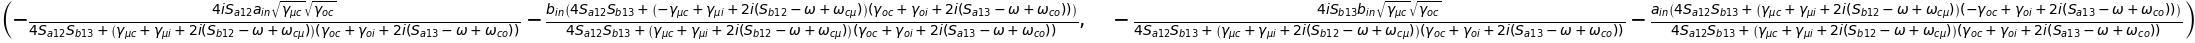

In [26]:
A,B,C,D,F,G =sym.symbols('A B C D F G')
a_in,a_out,b_in,b_out=sym.symbols('a_in a_out b_in b_out')

Sb12,Sa12=sym.symbols('S_b_1_2 S_a_1_2')
Sb13,Sa13=sym.symbols('S_b_1_3 S_a_1_3')
w, wcm,wco=sym.symbols('omega omega_c_mu omega_c_o',Real=True) 
gammi,gammc,gamoi,gamoc=sym.symbols('gamma_mu_i gamma_mu_c gamma_o_i gamma_o_c',positive = True, Real=True)

in_mat=Matrix([[A,-C],[G,-D]])
out_mat=Matrix([[-B,C],[-G,F]])

A_eq=(I*(wcm+Sb12-w)+(gammi-gammc)/2)
B_eq=(I*(wcm+Sb12-w)+(gammi+gammc)/2)
C_eq=-I*Sa12*sym.sqrt(gammc/gamoc)
D_eq=(I*(wco+Sa13-w)+(gamoi-gamoc)/2)
F_eq=(I*(wco+Sa13-w)+(gamoi+gamoc)/2)
G_eq=-I*Sb13*sym.sqrt(gamoc/gammc)

out_mat_eq=sym.simplify((out_mat.inv()*in_mat).subs({A:A_eq,B:B_eq,C:C_eq,D:D_eq,F:F_eq,G:G_eq}))*Matrix([[b_in],[a_in]])
bout_eq=out_mat_eq[0]
aout_eq=out_mat_eq[1]
bout_eq, aout_eq

$b_{out}=C_{ab}a_{in}+C_{bb}b_{in}$


$a_{out}=C_{aa}a_{in}+C{ba}b_{in}$

In [27]:
Cab=bout_eq.subs({b_in:0})/a_in
Cbb=bout_eq.subs({a_in:0})/b_in
Caa=aout_eq.subs({b_in:0})/a_in
Cba=aout_eq.subs({a_in:0})/b_in

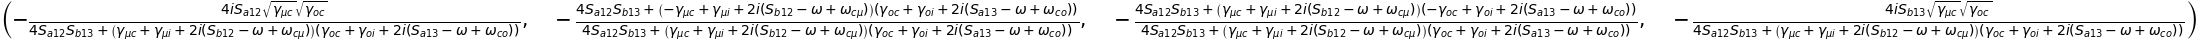

In [28]:
Cab,Cbb,Caa,Cba

In [29]:
print('C_{ab}=&'+sym.latex(Cab)+'\\\\')
print('C_{bb}=&'+sym.latex(Cbb)+'\\\\')
print('C_{aa}=&'+sym.latex(Caa)+'\\\\')
print('C_{ba}=&'+sym.latex(Cba))


C_{ab}=&- \frac{4 i S_{a 1 2} \sqrt{\gamma_{\mu c}} \sqrt{\gamma_{o c}}}{4 S_{a 1 2} S_{b 1 3} + \left(\gamma_{\mu c} + \gamma_{\mu i} + 2 i \left(S_{b 1 2} - \omega + \omega_{c \mu}\right)\right) \left(\gamma_{o c} + \gamma_{o i} + 2 i \left(S_{a 1 3} - \omega + \omega_{c o}\right)\right)}\\
C_{bb}=&- \frac{4 S_{a 1 2} S_{b 1 3} + \left(- \gamma_{\mu c} + \gamma_{\mu i} + 2 i \left(S_{b 1 2} - \omega + \omega_{c \mu}\right)\right) \left(\gamma_{o c} + \gamma_{o i} + 2 i \left(S_{a 1 3} - \omega + \omega_{c o}\right)\right)}{4 S_{a 1 2} S_{b 1 3} + \left(\gamma_{\mu c} + \gamma_{\mu i} + 2 i \left(S_{b 1 2} - \omega + \omega_{c \mu}\right)\right) \left(\gamma_{o c} + \gamma_{o i} + 2 i \left(S_{a 1 3} - \omega + \omega_{c o}\right)\right)}\\
C_{aa}=&- \frac{4 S_{a 1 2} S_{b 1 3} + \left(\gamma_{\mu c} + \gamma_{\mu i} + 2 i \left(S_{b 1 2} - \omega + \omega_{c \mu}\right)\right) \left(- \gamma_{o c} + \gamma_{o i} + 2 i \left(S_{a 1 3} - \omega + \omega_{c o}\right)\right)}{4 S_{a 1 2}

In [30]:
Cab_lam=sym.lambdify((w,wco,wcm,gamoi,gammi, gamoc,gammc, Sa12,Sb12,Sa13,Sb13),Cab)
Cbb_lam=sym.lambdify((w,wco,wcm,gamoi,gammi, gamoc,gammc, Sa12,Sb12,Sa13,Sb13),Cbb)
Caa_lam=sym.lambdify((w,wco,wcm,gamoi,gammi, gamoc,gammc, Sa12,Sb12,Sa13,Sb13),Caa)
Cba_lam=sym.lambdify((w,wco,wcm,gamoi,gammi, gamoc,gammc, Sa12,Sb12,Sa13,Sb13),Cba)

In [31]:
def convert_coeffs(wval,deloval,delmval,p):
    rho0int, rhoaint, rhobint= find_rhoint(deloval,delmval,p)
    Sa12_val=p['gm']*p['Nm']*rhoaint[3]
    Sa13_val=p['go']*p['No']*rhoaint[6]
    Sb12_val=p['gm']*p['Nm']*rhobint[3]
    Sb13_val=p['go']*p['No']*rhobint[6]
    Cab_val=(Cab_lam(wval,2*pi*p['freqo'],2*pi*p['freqmu'],p['gammaoi'],p['gammami'],p['gammaoc'],p['gammamc'], Sa12_val,Sb12_val,Sa13_val,Sb13_val))[0]
    Cbb_val=(Cbb_lam(wval,2*pi*p['freqo'],2*pi*p['freqmu'],p['gammaoi'],p['gammami'],p['gammaoc'],p['gammamc'], Sa12_val,Sb12_val,Sa13_val,Sb13_val))[0]
    Caa_val=(Caa_lam(wval,2*pi*p['freqo'],2*pi*p['freqmu'],p['gammaoi'],p['gammami'],p['gammaoc'],p['gammamc'], Sa12_val,Sb12_val,Sa13_val,Sb13_val))[0]
    Cba_val=(Cba_lam(wval,2*pi*p['freqo'],2*pi*p['freqmu'],p['gammaoi'],p['gammami'],p['gammaoc'],p['gammamc'], Sa12_val,Sb12_val,Sa13_val,Sb13_val))[0]
    return Cab_val, Cbb_val, Caa_val, Cba_val

In [63]:
def convert_coeffs_2(wval,deloval,delmval,p):
    rho0int, rhoaint, rhobint= find_rhoint_2(deloval,delmval,p)
    Sa12_val=p['gm']*p['Nm']*rhoaint[3]
    Sa13_val=p['go']*p['No']*rhoaint[6]
    Sb12_val=p['gm']*p['Nm']*rhobint[3]
    Sb13_val=p['go']*p['No']*rhobint[6]
    Cab_val=(Cab_lam(wval,2*pi*p['freqo'],2*pi*p['freqmu'],p['gammaoi'],p['gammami'],p['gammaoc'],p['gammamc'], Sa12_val,Sb12_val,Sa13_val,Sb13_val))[0]
    Cbb_val=(Cbb_lam(wval,2*pi*p['freqo'],2*pi*p['freqmu'],p['gammaoi'],p['gammami'],p['gammaoc'],p['gammamc'], Sa12_val,Sb12_val,Sa13_val,Sb13_val))[0]
    Caa_val=(Caa_lam(wval,2*pi*p['freqo'],2*pi*p['freqmu'],p['gammaoi'],p['gammami'],p['gammaoc'],p['gammamc'], Sa12_val,Sb12_val,Sa13_val,Sb13_val))[0]
    Cba_val=(Cba_lam(wval,2*pi*p['freqo'],2*pi*p['freqmu'],p['gammaoi'],p['gammami'],p['gammaoc'],p['gammamc'], Sa12_val,Sb12_val,Sa13_val,Sb13_val))[0]
    return Cab_val, Cbb_val, Caa_val, Cba_val

In [190]:
def S_func(deloval,delmval,p):
    rho0int, rhoaint, rhobint= find_rhoint_2(deloval,delmval,p)
    Sa12_val=p['gm']*p['Nm']*rhoaint[3]
    Sa13_val=p['go']*p['No']*rhoaint[6]
    Sb12_val=p['gm']*p['Nm']*rhobint[3]
    Sb13_val=p['go']*p['No']*rhobint[6]
    return Sa12_val, Sa13_val, Sb12_val, Sb13_val

In [192]:
start_time=time.time()
Delvals=np.linspace(-6e8,6e8,5)
Cab_vals=np.zeros(len(Delvals),dtype=np.complex_)
Cbb_vals=np.zeros(len(Delvals),dtype=np.complex_)
Caa_vals=np.zeros(len(Delvals),dtype=np.complex_)
Cba_vals=np.zeros(len(Delvals),dtype=np.complex_)
for ii,wval in enumerate(wvals):
    Cab_vals[ii], Cbb_vals[ii], Caa_vals[ii], Cba_vals[ii]=convert_coeffs_2(10e6,-4e6,p)
    elapsed_time=time.time()-start_time
    print('  Time: ' + str(elapsed_time))

TypeError: convert_coeffs_2() missing 1 required positional argument: 'p'

In [193]:
start_time=time.time()
Delvals=np.linspace(-3e8,3e8,40)
Sa12_vals=np.zeros(len(Delvals),dtype=np.complex_)
Sa13_vals=np.zeros(len(Delvals),dtype=np.complex_)
Sb12_vals=np.zeros(len(Delvals),dtype=np.complex_)
Sb13_vals=np.zeros(len(Delvals),dtype=np.complex_)
for ii,Delval in enumerate(Delvals):
    Sa12_vals[ii], Sa13_vals[ii], Sb12_vals[ii], Sb13_vals[ii]=S_func(4e6,4e6-Delval,p)
    elapsed_time=time.time()-start_time
    print('  Time: ' + str(elapsed_time))


  Time: 5.8786656856536865
  Time: 11.728524684906006
  Time: 17.547773122787476
  Time: 23.31695318222046
  Time: 29.10692262649536
  Time: 34.89164853096008
  Time: 40.76905131340027
  Time: 46.570735931396484
  Time: 52.36077523231506
  Time: 58.139288663864136
  Time: 63.925896406173706
  Time: 69.75948333740234
  Time: 75.54687213897705
  Time: 81.37471771240234
  Time: 87.11326193809509
  Time: 92.90605306625366
  Time: 98.78100395202637
  Time: 104.5821840763092
  Time: 110.37591433525085
  Time: 116.29515480995178
  Time: 122.2180655002594
  Time: 128.07556438446045
  Time: 133.97041630744934
  Time: 139.92555594444275
  Time: 145.79750990867615
  Time: 151.61681079864502
  Time: 157.5505838394165
  Time: 163.46713876724243
  Time: 169.28931331634521
  Time: 175.1356279850006
  Time: 180.93011260032654
  Time: 186.76969861984253
  Time: 192.548344373703
  Time: 198.3241946697235
  Time: 204.08951258659363
  Time: 209.8852198123932
  Time: 215.64874982833862
  Time: 221.39270567

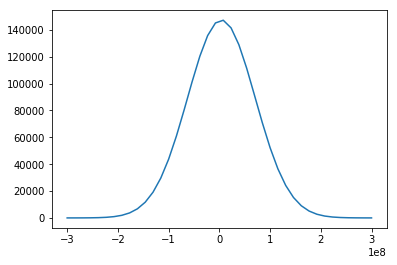

In [196]:
plt.plot(Delvals, np.abs(Sa12_vals))

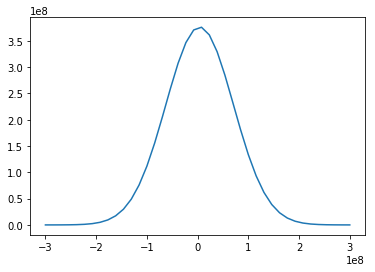

In [197]:
plt.plot(Delvals, np.abs(Sa13_vals))

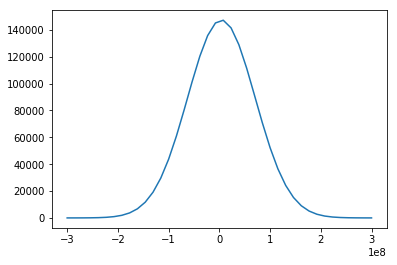

In [198]:
plt.plot(Delvals, np.abs(Sb12_vals))

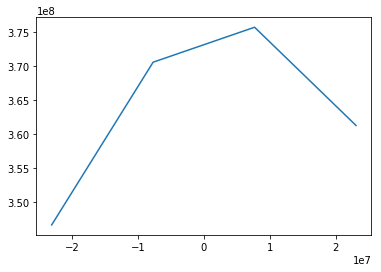

In [203]:
plt.plot(Delvals[18:22], np.abs(Sb13_vals[18:22]))

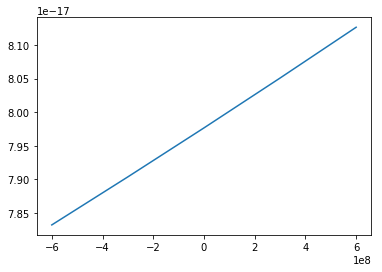

In [72]:
plt.plot(wvals,np.abs(Cab_vals))

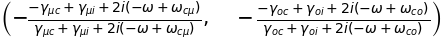

In [35]:
Cbb_noatoms=Cbb.subs({Sa12:0,Sa13:0,Sb12:0,Sb13:0})
Caa_noatoms=Caa.subs({Sa12:0,Sa13:0,Sb12:0,Sb13:0})
Cbb_noatoms, Caa_noatoms

In [36]:
L0.subs({nbath:0}).nullspace()

⎡⎡1⎤⎤
⎢⎢ ⎥⎥
⎢⎢0⎥⎥
⎢⎢ ⎥⎥
⎢⎢0⎥⎥
⎢⎢ ⎥⎥
⎢⎢0⎥⎥
⎢⎢ ⎥⎥
⎢⎢0⎥⎥
⎢⎢ ⎥⎥
⎢⎢0⎥⎥
⎢⎢ ⎥⎥
⎢⎢0⎥⎥
⎢⎢ ⎥⎥
⎢⎢0⎥⎥
⎢⎢ ⎥⎥
⎣⎣0⎦⎦

In [37]:
rho_0T=sym.Matrix([1,0,0,0,0,0,0,0,0])
La*rho_0T

⎡  0  ⎤
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎢-ⅈ⋅gₒ⎥
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎢  __ ⎥
⎢ⅈ⋅gₒ ⎥
⎢     ⎥
⎢  0  ⎥
⎢     ⎥
⎣  0  ⎦

In [38]:
L0.subs({nbath:0}).det()

In [39]:
singular_test_bad(L0.subs({nbath:0}))

In [40]:
L0

⎡-γₘᵤ⋅n_b                     0                                     0         
⎢                                                                             
⎢                   γ_2d   γₘᵤ⋅n_b   γₘᵤ⋅(n_b + 1)                    _       
⎢   0      -ⅈ⋅δₘᵤ - ──── - ─────── - ─────────────                 -ⅈ⋅Ω       
⎢                    2        2            2                                  
⎢                                                                             
⎢                                                           γ₁₃   γ₂₃   γ_3d  
⎢   0                       -ⅈ⋅Ω                    -ⅈ⋅δₒ - ─── - ─── - ──── -
⎢                                                            2     2     2    
⎢                                                                             
⎢                                                                             
⎢   0                         0                                     0         
⎢                                                   

In [41]:
Laa=L-L.subs({a:0})
#Lad=Laa.subs({(a):0})/a
Laa=Laa.subs({sym.conjugate(a):0})/a
Lad=(L-L.subs({a:0})-a*Laa).subs({a:1})

In [42]:
La-Lad

⎡  0    0  0    0    0  0  ⅈ⋅gₒ    0     0  ⎤
⎢                                           ⎥
⎢  0    0  0    0    0  0    0    ⅈ⋅gₒ   0  ⎥
⎢                                           ⎥
⎢-ⅈ⋅gₒ  0  0    0    0  0    0     0    ⅈ⋅gₒ⎥
⎢                                           ⎥
⎢  0    0  0    0    0  0    0     0     0  ⎥
⎢                                           ⎥
⎢  0    0  0    0    0  0    0     0     0  ⎥
⎢                                           ⎥
⎢  0    0  0  -ⅈ⋅gₒ  0  0    0     0     0  ⎥
⎢                                           ⎥
⎢  0    0  0    0    0  0    0     0     0  ⎥
⎢                                           ⎥
⎢  0    0  0    0    0  0    0     0     0  ⎥
⎢                                           ⎥
⎣  0    0  0    0    0  0  -ⅈ⋅gₒ   0     0  ⎦

In [43]:
Laa

⎡  0    0  0    0    0  0  ⅈ⋅gₒ    0     0  ⎤
⎢                                           ⎥
⎢  0    0  0    0    0  0    0    ⅈ⋅gₒ   0  ⎥
⎢                                           ⎥
⎢-ⅈ⋅gₒ  0  0    0    0  0    0     0    ⅈ⋅gₒ⎥
⎢                                           ⎥
⎢  0    0  0    0    0  0    0     0     0  ⎥
⎢                                           ⎥
⎢  0    0  0    0    0  0    0     0     0  ⎥
⎢                                           ⎥
⎢  0    0  0  -ⅈ⋅gₒ  0  0    0     0     0  ⎥
⎢                                           ⎥
⎢  0    0  0    0    0  0    0     0     0  ⎥
⎢                                           ⎥
⎢  0    0  0    0    0  0    0     0     0  ⎥
⎢                                           ⎥
⎣  0    0  0    0    0  0  -ⅈ⋅gₒ   0     0  ⎦

In [44]:
singular_test_bad(L0)

array([-3.85060195e+16+9.18447096e+10j, -1.14171826e-13-7.63131035e-02j,
       -2.63810448e+15-2.79549179e+09j,  9.98890890e-14+3.79311377e-02j,
        2.83184006e-12+9.18783192e-02j,  9.93525232e-13-1.77196336e-02j,
        8.12671489e-17-4.54559856e-06j, -1.12975704e-11-1.28380140e+01j,
        1.82791956e-15-4.42264478e-05j,  7.29050623e-11+5.13486233e+00j])

In [45]:
L0.inv(method="LU")

ValueError: Matrix det == 0; not invertible.

In [ ]:
L0

In [ ]:
L0.rref()

In [ ]:
(L0.subs({nbath:0})).inv()

In [ ]:
rho1=(L0.nullspace()[0])
rho2=rho1/(rho1[0]+rho1[4]+rho1[8])


In [ ]:
sym.simplify(rho2).subs({nbath:1})

In [ ]:
def find_rhoint_T0(deloval,delmval,p):
    rho0=np.array([[1,0,0,0,0,0,0,0,0]])
    L0_mat=L0_fun(deloval,delmval,p['gamma13'],p['gamma23'],p['gamma2d'],p['gamma3d'], p['nbath'],p['gammamu'],p['Omega'],p['go'],p['gm'])
    La_mat=La_fun(p['go'],p['gm'])
    Lb_mat=La_fun(p['go'],p['gm'])
    print(La_mat.shape)
    rhoa=-np.matrix(np.linalg.inv(L0_mat))*np.matrix(La_mat)*np.matrix(rho0.T)
    rhob=-np.matrix(np.linalg.inv(L0_mat))*np.matrix(Lb_mat)*np.matrix(rho0.T)
    #rhoa=-np.matmul(np.matmul(np.linalg.inv(L0_mat),La_mat),rho0)
    #rhob=-np.matmul(np.matmul(np.linalg.inv(L0_mat),Lb_mat),rho0)
    return rho0, np.array(rhoa)[:], np.array(rhob)[1,:]

In [ ]:
find_rhoint_T0(10e6,-10e4,p)

In [ ]:
nbathvals=np.linspace(1,20,20)
rhoavals=np.zeros((20,9),dtype=np.complex)
rhobvals=np.zeros((20,9),dtype=np.complex)
for ii, nbathval in enumerate(nbathvals):
    p['nbath']=nbathval
    dum1, rhoavals[ii,:],rhoavals[ii,:]=find_rhoint_T0(10e6,10e4,p)


In [53]:
(L0.T*L0).det()

KeyboardInterrupt: 

In [52]:
singular_test_bad(L0.T*L0)

array([ 5.99852866e+53+4.47669936e+47j,  2.24809766e+55-1.15917238e+50j,
        7.23011428e+53-1.45700224e+48j, -2.36744572e+58-1.44605486e+51j,
       -8.00117420e+55-3.01141286e+49j, -9.81115617e+56+2.00914630e+50j,
       -4.39000354e+46+2.22132690e+41j, -3.95537408e+51+2.54196212e+46j,
        1.99742276e+49-3.66829801e+42j,  5.93435718e+55-9.93213380e+47j])

In [124]:
Delvals=[1e8]#np.linspace(-3e8,3e8,10)
wvals=np.linspace(3e10,3.5e10,30)
Cab_vals=np.zeros((len(Delvals),len(wvals)),dtype=np.complex_)
Cbb_vals=np.zeros((len(Delvals),len(wvals)),dtype=np.complex_)
Caa_vals=np.zeros((len(Delvals),len(wvals)),dtype=np.complex_)
Cba_vals=np.zeros((len(Delvals),len(wvals)),dtype=np.complex_)
start_time=time.time()
for ii,wval in enumerate(wvals):
    for jj, Delval in enumerate(Delvals):
        Cab_vals[jj,ii], Cbb_vals[jj,ii], Caa_vals[jj,ii], Cba_vals[jj,ii]=convert_coeffs_2(wval,4e6,4e6-Delval,p)
        elapsed_time=time.time()-start_time
        print('  Time: ' + str(elapsed_time))


  Time: 6.09228777885437
  Time: 12.255543231964111
  Time: 18.06927728652954
  Time: 23.92610001564026
  Time: 29.99709701538086
  Time: 35.49210238456726
  Time: 41.018431186676025
  Time: 46.55916166305542
  Time: 52.0711190700531
  Time: 57.555941104888916
  Time: 63.014121294021606
  Time: 68.53200101852417
  Time: 74.15677690505981
  Time: 80.07329869270325
  Time: 86.15195035934448
  Time: 92.10195016860962
  Time: 97.94126391410828
  Time: 103.83790159225464
  Time: 109.77167391777039
  Time: 115.69171047210693
  Time: 121.53129601478577
  Time: 127.4794487953186
  Time: 133.4962978363037
  Time: 139.40129351615906
  Time: 145.22612619400024
  Time: 151.07799673080444
  Time: 156.9234492778778
  Time: 162.753826379776
  Time: 168.72331070899963
  Time: 174.7907464504242


/home/peter/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=100000000.0, top=100000000.0
  'bottom=%s, top=%s') % (bottom, top))


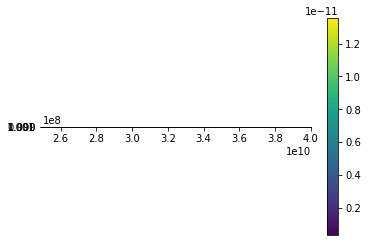

In [122]:
plt.imshow(np.abs(Cba_vals),extent=(np.min(wvals),np.max(wvals), np.min(Delvals),np.max(Delvals)))
plt.colorbar()

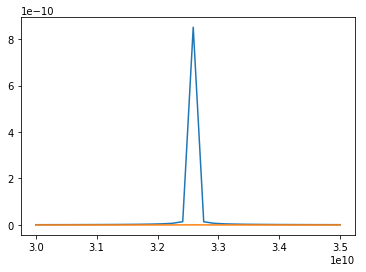

In [130]:
plt.plot(wvals,np.abs(Cba_vals[0,:]))
plt.plot(wvals,np.abs(Cab_vals[0,:]))

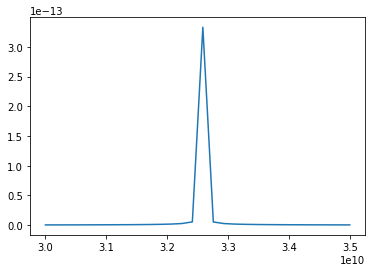

In [129]:
plt.plot(wvals,np.abs(Cab_vals[0,:]))

In [133]:
p['freqmu']*2*pi/1e10

In [134]:
p['gammamc'],p['gammami']

In [136]:
Delvalsm=np.linspace(-3e8,3e8,40)
wvalsm=np.linspace(p['freqmu']*2*pi-2e9,p['freqmu']*2*pi+2e9,60)
Cab_mvals=np.zeros((len(Delvalsm),len(wvalsm)),dtype=np.complex_)
Cbb_mvals=np.zeros((len(Delvalsm),len(wvalsm)),dtype=np.complex_)
Caa_mvals=np.zeros((len(Delvalsm),len(wvalsm)),dtype=np.complex_)
Cba_mvals=np.zeros((len(Delvalsm),len(wvalsm)),dtype=np.complex_)
start_time=time.time()
for ii,wval in enumerate(wvalsm):
    for jj, Delval in enumerate(Delvalsm):
        Cab_mvals[jj,ii], Cbb_mvals[jj,ii], Caa_mvals[jj,ii], Cba_mvals[jj,ii]=convert_coeffs_2(wval,4e6,4e6-Delval,p)
        elapsed_time=time.time()-start_time
        print('    ' + str(ii)+'  Time: ' + str(elapsed_time))

    0  Time: 5.920106887817383
    0  Time: 11.823271989822388
    0  Time: 17.68142032623291
    0  Time: 23.56392502784729
    0  Time: 29.494550943374634
    0  Time: 35.37059569358826
    0  Time: 41.242268323898315
    0  Time: 47.13971424102783
    0  Time: 53.00556802749634
    0  Time: 58.81436538696289
    0  Time: 64.68308424949646
    0  Time: 70.50197696685791
    0  Time: 76.32121920585632
    0  Time: 82.1589138507843
    0  Time: 88.01985812187195
    0  Time: 93.89260506629944
    0  Time: 99.75868368148804
    0  Time: 105.59897375106812
    0  Time: 111.42201566696167
    0  Time: 117.26017880439758
    0  Time: 123.10156321525574
    0  Time: 128.93824934959412
    0  Time: 134.7931478023529
    0  Time: 140.59545826911926
    0  Time: 146.43446135520935
    0  Time: 152.3314073085785
    0  Time: 158.24787521362305
    0  Time: 164.07926106452942
    0  Time: 169.94893789291382
    0  Time: 175.7651445865631
    0  Time: 181.60369873046875
    0  Time: 187.471292734

    6  Time: 1505.0817301273346
    6  Time: 1510.6350371837616
    6  Time: 1516.166134595871
    6  Time: 1521.7181813716888
    6  Time: 1527.2796874046326
    6  Time: 1532.833663702011
    6  Time: 1538.380737543106
    6  Time: 1543.9410004615784
    6  Time: 1549.4801785945892
    6  Time: 1555.030200958252
    6  Time: 1560.5781004428864
    6  Time: 1566.1344957351685
    6  Time: 1571.702544927597
    6  Time: 1577.265843629837
    6  Time: 1582.8180310726166
    6  Time: 1588.3902049064636
    6  Time: 1593.954380273819
    6  Time: 1599.5394206047058
    7  Time: 1605.1071865558624
    7  Time: 1610.699705839157
    7  Time: 1616.2772612571716
    7  Time: 1621.8477659225464
    7  Time: 1627.4315524101257
    7  Time: 1633.0156733989716
    7  Time: 1638.605689048767
    7  Time: 1644.1868906021118
    7  Time: 1649.7617268562317
    7  Time: 1655.33495759964
    7  Time: 1660.920438528061
    7  Time: 1666.4874520301819
    7  Time: 1672.0754489898682
    7  Time: 1677.66

    12  Time: 2931.773338317871
    12  Time: 2937.346539258957
    13  Time: 2942.9064354896545
    13  Time: 2948.47780418396
    13  Time: 2954.027357816696
    13  Time: 2959.586938381195
    13  Time: 2965.149526834488
    13  Time: 2970.729421854019
    13  Time: 2976.3027651309967
    13  Time: 2981.881761074066
    13  Time: 2987.4409596920013
    13  Time: 2993.018584251404
    13  Time: 2998.562956571579
    13  Time: 3004.130617380142
    13  Time: 3009.701546192169
    13  Time: 3015.283989429474
    13  Time: 3020.839104652405
    13  Time: 3026.4230263233185
    13  Time: 3031.990310192108
    13  Time: 3037.5662105083466
    13  Time: 3043.1240735054016
    13  Time: 3048.714651107788
    13  Time: 3054.291759252548
    13  Time: 3059.8557975292206
    13  Time: 3065.43626332283
    13  Time: 3071.017216682434
    13  Time: 3076.5971422195435
    13  Time: 3082.189145565033
    13  Time: 3087.756646633148
    13  Time: 3093.3508489131927
    13  Time: 3098.907804965973
 

    19  Time: 4347.765585422516
    19  Time: 4353.3518607616425
    19  Time: 4358.914411306381
    19  Time: 4364.49214887619
    19  Time: 4370.063987970352
    19  Time: 4375.628065824509
    19  Time: 4381.200566530228
    19  Time: 4386.760891914368
    19  Time: 4392.312381505966
    19  Time: 4397.8588972091675
    19  Time: 4403.422110080719
    19  Time: 4408.989917516708
    19  Time: 4414.560255765915
    19  Time: 4420.144899845123
    19  Time: 4425.709970235825
    19  Time: 4431.284574508667
    19  Time: 4436.841974973679
    19  Time: 4442.421150684357
    19  Time: 4447.986398220062
    19  Time: 4453.5931832790375
    19  Time: 4459.172167062759
    19  Time: 4464.742030143738
    19  Time: 4470.33849811554
    19  Time: 4475.930891275406
    19  Time: 4481.519663095474
    19  Time: 4487.09069776535
    19  Time: 4492.659648656845
    19  Time: 4498.253143310547
    20  Time: 4503.8321805000305
    20  Time: 4509.413824558258
    20  Time: 4514.967649459839
    20 

    25  Time: 5775.551104068756
    25  Time: 5781.192113399506
    25  Time: 5786.712007045746
    25  Time: 5792.267452478409
    25  Time: 5797.794681310654
    25  Time: 5803.3312776088715
    25  Time: 5808.873554229736
    25  Time: 5814.440567016602
    25  Time: 5820.002297639847
    25  Time: 5825.56963801384
    25  Time: 5831.130781650543
    25  Time: 5836.686169624329
    26  Time: 5842.240510940552
    26  Time: 5847.809598445892
    26  Time: 5853.377537488937
    26  Time: 5858.913297176361
    26  Time: 5864.463661670685
    26  Time: 5870.032249927521
    26  Time: 5875.592650175095
    26  Time: 5881.14608168602
    26  Time: 5886.67250585556
    26  Time: 5892.2398562431335
    26  Time: 5897.772612094879
    26  Time: 5903.326017618179
    26  Time: 5908.854640245438
    26  Time: 5914.404852151871
    26  Time: 5919.938608646393
    26  Time: 5925.516900539398
    26  Time: 5931.067415475845
    26  Time: 5936.650636911392
    26  Time: 5942.204300165176
    26  T

KeyboardInterrupt: 

In [210]:
Delvalso=[0,3e8]#np.linspace(-3e8,3e8,40)
wvalso=np.linspace(p['freqmu']*2*pi-2e8,p['freqmu']*2*pi+2e8,51)
Cab_ovals=np.zeros((len(Delvalso),len(wvalso)),dtype=np.complex_)
Cbb_ovals=np.zeros((len(Delvalso),len(wvalso)),dtype=np.complex_)
Caa_ovals=np.zeros((len(Delvalso),len(wvalso)),dtype=np.complex_)
Cba_ovals=np.zeros((len(Delvalso),len(wvalso)),dtype=np.complex_)
start_time=time.time()
for ii,wval in enumerate(wvalso):
    for jj, Delval in enumerate(Delvalso):
        Cab_ovals[jj,ii], Cbb_ovals[jj,ii], Caa_ovals[jj,ii], Cba_ovals[jj,ii]=convert_coeffs_2(wval,4e6,4e6-Delval,p)
        elapsed_time=time.time()-start_time
        print('    ' + str(ii)+'  Time: ' + str(elapsed_time))

    0  Time: 5.827578544616699
    0  Time: 11.612789869308472
    1  Time: 17.503934144973755
    1  Time: 23.334797382354736
    2  Time: 29.22673225402832
    2  Time: 35.27651286125183
    3  Time: 41.16396689414978
    3  Time: 47.137033462524414
    4  Time: 53.07735872268677
    4  Time: 59.09540915489197
    5  Time: 65.0077257156372
    5  Time: 71.02110171318054
    6  Time: 76.84224319458008
    6  Time: 82.69167900085449
    7  Time: 88.60780763626099
    7  Time: 94.41369652748108
    8  Time: 100.28538608551025
    8  Time: 106.18204975128174
    9  Time: 112.06725406646729
    9  Time: 117.94272685050964
    10  Time: 123.73882222175598
    10  Time: 129.56298780441284
    11  Time: 135.37765884399414
    11  Time: 141.20845556259155
    12  Time: 147.01958966255188
    12  Time: 152.93428921699524
    13  Time: 158.89165878295898
    13  Time: 164.73563480377197
    14  Time: 170.5325572490692
    14  Time: 176.44740056991577
    15  Time: 182.3633906841278
    15  Time

In [137]:
Caa_mvals_save1=Caa_mvals
Cab_mvals_save1=Cba_mvals
Cba_mvals_save1=Cba_mvals
Cbb_mvals_save1=Cbb_mvals

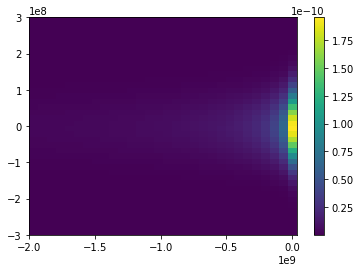

In [182]:
plt.imshow(np.abs(Cba_mvals[:,0:30]),extent=(np.min(wvalsm)-p['freqmu']*2*pi,np.max(wvalsm[30])-p['freqmu']*2*pi, np.min(Delvalsm),np.max(Delvalsm)),aspect='auto')
plt.colorbar()

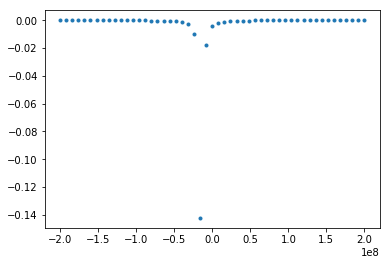

In [212]:
o1=0
o2=51
plt.plot(wvalso[o1:o2]-p['freqmu']*2*pi,np.abs(Cbb_ovals[0,o1:o2])-1,'.')

In [151]:
p['freqo']*2*pi

In [204]:
p['Nm']=p['Nm']*100
p['No']=p['No']*100

    0  Time: 6.458775281906128
    0  Time: 12.754687547683716
    0  Time: 19.087287425994873
    0  Time: 25.393773555755615
    0  Time: 31.722094774246216
    0  Time: 38.035908460617065
    0  Time: 44.34086060523987
    0  Time: 50.71999502182007
    0  Time: 57.14708113670349
    0  Time: 63.47776985168457
    0  Time: 69.7528784275055
    0  Time: 76.02090692520142
    0  Time: 82.31653928756714
    0  Time: 88.73483872413635
    0  Time: 95.14309644699097
    0  Time: 101.52748537063599
    0  Time: 107.84498453140259
    0  Time: 114.14326238632202
    0  Time: 120.47242879867554
    0  Time: 126.88948464393616
    0  Time: 133.41206049919128
    0  Time: 140.01700091362
    0  Time: 146.38833475112915
    0  Time: 153.1119420528412
    0  Time: 159.9242103099823
    0  Time: 166.76696157455444
    0  Time: 173.0568664073944
    0  Time: 179.3662965297699
    0  Time: 185.6759684085846
    0  Time: 192.09147548675537
    0  Time: 198.4783775806427
    0  Time: 204.79250717163

    5  Time: 1627.7556114196777
    5  Time: 1633.7476291656494
    5  Time: 1639.7422733306885
    5  Time: 1645.724395275116
    5  Time: 1651.7564010620117
    5  Time: 1657.750717163086
    5  Time: 1663.7518427371979
    5  Time: 1669.7563366889954
    5  Time: 1675.7560131549835
    6  Time: 1681.7553062438965
    6  Time: 1687.7953040599823
    6  Time: 1693.8206334114075
    6  Time: 1699.8774242401123
    6  Time: 1705.9545533657074
    6  Time: 1712.0150828361511
    6  Time: 1718.0552415847778
    6  Time: 1724.1129848957062
    6  Time: 1730.1400578022003
    6  Time: 1736.2008662223816
    6  Time: 1742.2476782798767
    6  Time: 1748.307823896408
    6  Time: 1754.3475787639618
    6  Time: 1760.386370420456
    6  Time: 1766.4054381847382
    6  Time: 1772.4526891708374
    6  Time: 1778.492577791214
    6  Time: 1784.5132238864899
    6  Time: 1790.5644943714142
    6  Time: 1796.611823797226
    6  Time: 1802.660796403885
    6  Time: 1808.724716424942
    6  Time: 181

    11  Time: 3183.605706691742
    11  Time: 3189.6658613681793
    11  Time: 3195.743921518326
    11  Time: 3201.7983536720276
    11  Time: 3207.8572237491608
    11  Time: 3213.9421484470367
    11  Time: 3219.9989914894104
    11  Time: 3226.063441991806
    11  Time: 3232.137459039688
    11  Time: 3238.207060098648
    11  Time: 3244.25718998909
    11  Time: 3250.312106847763
    11  Time: 3256.3821070194244
    11  Time: 3262.4361159801483
    11  Time: 3268.5054721832275
    11  Time: 3274.5795290470123
    11  Time: 3280.609135389328
    11  Time: 3286.6400666236877
    11  Time: 3292.6779153347015
    11  Time: 3298.7382974624634
    11  Time: 3304.75416636467
    12  Time: 3310.772973060608
    12  Time: 3316.7970747947693
    12  Time: 3322.838120698929
    12  Time: 3328.883767604828
    12  Time: 3334.954052209854
    12  Time: 3340.992978811264
    12  Time: 3347.0230927467346
    12  Time: 3353.0759637355804
    12  Time: 3359.1222145557404
    12  Time: 3365.1563498

    17  Time: 4718.038243055344
    17  Time: 4724.071731328964
    17  Time: 4730.162797212601
    17  Time: 4736.195034980774
    17  Time: 4742.220097541809
    17  Time: 4748.233897447586
    17  Time: 4754.255215167999
    17  Time: 4760.301137685776
    17  Time: 4766.311180830002
    17  Time: 4772.404652118683
    17  Time: 4778.445930957794
    17  Time: 4784.479042291641
    17  Time: 4790.5052053928375
    17  Time: 4796.729298830032
    17  Time: 4802.823099851608
    17  Time: 4808.821446895599
    17  Time: 4814.8257937431335
    17  Time: 4820.8367574214935
    17  Time: 4826.866107463837
    17  Time: 4832.929176330566
    17  Time: 4838.968816518784
    17  Time: 4844.975145816803
    17  Time: 4850.997361898422
    17  Time: 4857.031183481216
    17  Time: 4863.044877052307
    17  Time: 4869.10843372345
    17  Time: 4875.138378381729
    17  Time: 4881.144421577454
    17  Time: 4887.157844543457
    17  Time: 4893.219002962112
    17  Time: 4899.2277739048
    17  

    22  Time: 6263.926043748856
    22  Time: 6269.935508012772
    22  Time: 6275.9449627399445
    22  Time: 6281.949332475662
    22  Time: 6287.97856426239
    22  Time: 6293.998079061508
    23  Time: 6300.011436223984
    23  Time: 6306.051822423935
    23  Time: 6312.077822446823
    23  Time: 6318.0970458984375
    23  Time: 6324.104859113693
    23  Time: 6330.125668525696
    23  Time: 6336.183427095413
    23  Time: 6342.207286119461
    23  Time: 6348.227232933044
    23  Time: 6354.262011051178
    23  Time: 6360.292170524597
    23  Time: 6366.318229913712
    23  Time: 6372.345947504044
    23  Time: 6378.362486839294
    23  Time: 6384.3804540634155
    23  Time: 6390.388857603073
    23  Time: 6396.396323680878
    23  Time: 6402.411095619202
    23  Time: 6408.42794752121
    23  Time: 6414.435650348663
    23  Time: 6420.456507444382
    23  Time: 6426.477061986923
    23  Time: 6432.516105413437
    23  Time: 6438.541430711746
    23  Time: 6444.559998750687
    23 

    28  Time: 7809.685353755951
    28  Time: 7815.7295751571655
    28  Time: 7821.756097316742
    28  Time: 7827.81513261795
    28  Time: 7833.856689691544
    28  Time: 7839.910953044891
    28  Time: 7845.963963031769
    28  Time: 7852.010055303574
    28  Time: 7858.069583654404
    28  Time: 7864.123233795166
    28  Time: 7870.192506790161
    28  Time: 7876.2479503154755
    28  Time: 7882.298335552216
    28  Time: 7888.376713275909
    28  Time: 7894.464943647385
    28  Time: 7900.526259660721
    28  Time: 7906.602279186249
    28  Time: 7912.655327796936
    28  Time: 7918.6982181072235
    28  Time: 7924.7641518116
    29  Time: 7930.802628040314
    29  Time: 7936.851973772049
    29  Time: 7942.887860298157
    29  Time: 7948.93981719017
    29  Time: 7954.994560956955
    29  Time: 7961.040450334549
    29  Time: 7967.10568356514
    29  Time: 7973.164272546768
    29  Time: 7979.20347070694
    29  Time: 7985.25400686264
    29  Time: 7991.281872034073
    29  Time

    34  Time: 9360.299786567688
    34  Time: 9366.313321352005
    34  Time: 9372.303413391113
    34  Time: 9378.315082550049
    34  Time: 9384.337996006012
    34  Time: 9390.324238061905
    34  Time: 9396.329294204712
    34  Time: 9402.328407287598
    34  Time: 9408.342318534851
    34  Time: 9414.357477426529
    34  Time: 9420.350990533829
    34  Time: 9426.34644985199
    34  Time: 9432.352127075195
    34  Time: 9438.341565847397
    34  Time: 9444.337150812149
    34  Time: 9450.353016376495
    34  Time: 9456.408605098724
    34  Time: 9462.432965755463
    34  Time: 9468.46082353592
    34  Time: 9474.496269702911
    34  Time: 9480.530975341797
    34  Time: 9486.556348323822
    34  Time: 9492.590501070023
    34  Time: 9498.617130756378
    34  Time: 9504.628905534744
    34  Time: 9510.642963409424
    34  Time: 9516.653071165085
    34  Time: 9522.654132843018
    34  Time: 9528.675038099289
    34  Time: 9534.714320421219
    34  Time: 9540.742743730545
    34  Ti

    39  Time: 10886.874989509583
    39  Time: 10892.933282613754
    39  Time: 10898.99639582634
    39  Time: 10905.045305252075
    39  Time: 10911.077612400055
    40  Time: 10917.118834495544
    40  Time: 10923.147582530975
    40  Time: 10929.17820239067
    40  Time: 10935.213984012604
    40  Time: 10941.257217884064
    40  Time: 10947.300724983215
    40  Time: 10953.315594911575
    40  Time: 10959.326935529709
    40  Time: 10965.344884634018
    40  Time: 10971.344471931458
    40  Time: 10977.363297462463
    40  Time: 10983.371258020401
    40  Time: 10989.406749010086
    40  Time: 10995.43680715561
    40  Time: 11001.462589025497
    40  Time: 11007.485577583313
    40  Time: 11013.537909030914
    40  Time: 11019.583571195602
    40  Time: 11025.623559713364
    40  Time: 11031.63694190979
    40  Time: 11037.670696020126
    40  Time: 11043.709286928177
    40  Time: 11049.754439592361
    40  Time: 11055.805697202682
    40  Time: 11061.832540988922
    40  Time: 

    45  Time: 12397.48892378807
    45  Time: 12403.521983861923
    45  Time: 12409.554936647415
    45  Time: 12415.609753608704
    45  Time: 12421.626804828644
    45  Time: 12427.660967588425
    45  Time: 12433.690520524979
    45  Time: 12439.734272956848
    45  Time: 12445.76844072342
    45  Time: 12451.813014507294
    45  Time: 12457.857692718506
    45  Time: 12463.901264190674
    45  Time: 12469.92973947525
    45  Time: 12475.97281074524
    45  Time: 12482.023905038834
    45  Time: 12488.060945034027
    45  Time: 12494.096784830093
    45  Time: 12500.138711929321
    45  Time: 12506.16268157959
    45  Time: 12512.188213825226
    45  Time: 12518.210164546967
    45  Time: 12524.233051538467
    45  Time: 12530.275258541107
    45  Time: 12536.31760263443
    45  Time: 12542.33847117424
    46  Time: 12548.359769582748
    46  Time: 12554.411757946014
    46  Time: 12560.452917098999
    46  Time: 12566.49762392044
    46  Time: 12572.565732955933
    46  Time: 1257

    51  Time: 13901.861990213394
    51  Time: 13907.901922941208
    51  Time: 13913.922794818878
    51  Time: 13919.950846195221
    51  Time: 13925.993042945862
    51  Time: 13932.035125017166
    51  Time: 13938.06252169609
    51  Time: 13944.124566316605
    51  Time: 13950.158053398132
    51  Time: 13956.191447734833
    51  Time: 13962.239941358566
    51  Time: 13968.269667387009
    51  Time: 13974.299788951874
    51  Time: 13980.38191652298
    51  Time: 13986.395455598831
    51  Time: 13992.402762889862
    51  Time: 13998.437800645828
    51  Time: 14004.462574243546
    51  Time: 14010.495532035828
    51  Time: 14016.545462846756
    51  Time: 14022.572583675385
    51  Time: 14028.576877593994
    51  Time: 14034.600725650787
    51  Time: 14040.616203546524
    51  Time: 14046.622039794922
    51  Time: 14052.63949751854
    51  Time: 14058.691400766373
    51  Time: 14064.726161718369
    51  Time: 14070.738250494003
    51  Time: 14076.773244857788
    51  Time:

    56  Time: 15408.661062717438
    56  Time: 15414.762838602066
    56  Time: 15420.783271312714
    56  Time: 15426.796913146973
    56  Time: 15432.836440086365
    56  Time: 15438.867342710495
    56  Time: 15444.90111708641
    56  Time: 15450.953443527222
    56  Time: 15457.01053237915
    56  Time: 15463.05213356018
    56  Time: 15469.104098796844
    56  Time: 15475.166092395782
    56  Time: 15481.22777223587
    56  Time: 15487.256723880768
    56  Time: 15493.297245502472
    56  Time: 15499.346615314484
    56  Time: 15505.4086124897
    56  Time: 15511.466821670532
    56  Time: 15517.535973072052
    56  Time: 15523.597450494766
    57  Time: 15529.668994188309
    57  Time: 15535.736814260483
    57  Time: 15541.803824424744
    57  Time: 15547.864365816116
    57  Time: 15553.914228916168
    57  Time: 15559.969338655472
    57  Time: 15566.02523946762
    57  Time: 15572.109098911285
    57  Time: 15578.17753791809
    57  Time: 15584.206674337387
    57  Time: 1559

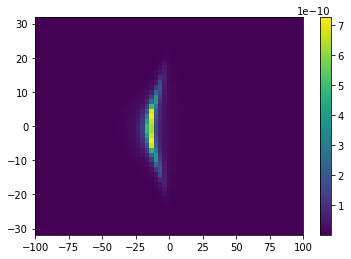

In [227]:
Delvalsm=np.linspace(-2e8,2e8,45)
wvalsm=np.linspace(p['freqmu']*2*pi-1e8,p['freqmu']*2*pi+1e8,61)
Cab_mvals=np.zeros((len(Delvalsm),len(wvalsm)),dtype=np.complex_)
Cbb_mvals=np.zeros((len(Delvalsm),len(wvalsm)),dtype=np.complex_)
Caa_mvals=np.zeros((len(Delvalsm),len(wvalsm)),dtype=np.complex_)
Cba_mvals=np.zeros((len(Delvalsm),len(wvalsm)),dtype=np.complex_)
start_time=time.time()
for ii,wval in enumerate(wvalsm):
    for jj, Delval in enumerate(Delvalsm):
        Cab_mvals[jj,ii], Cbb_mvals[jj,ii], Caa_mvals[jj,ii], Cba_mvals[jj,ii]=convert_coeffs_2(wval,4e6,4e6-Delval,p)
        elapsed_time=time.time()-start_time
        print('    ' + str(ii)+'  Time: ' + str(elapsed_time))
plt.imshow(np.abs(Cba_mvals)**2,extent=((np.min(wvalsm)-p['freqmu']*2*pi)*1e-6,(np.max(wvalsm)-p['freqmu']*2*pi)*1e-6, np.min(Delvalsm)/2/pi*1e-6,np.max(Delvalsm)/2/pi*1e-6),aspect='auto')
plt.colorbar()
plt.savefig('cavity_detunea_2.pdf')

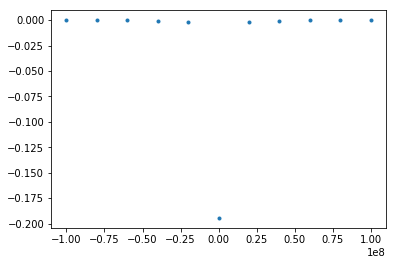

In [214]:
o1=0
o2=51
plt.plot(wvalsm[o1:o2]-p['freqmu']*2*pi,np.abs(Cbb_mvals[0,o1:o2])-1,'.')

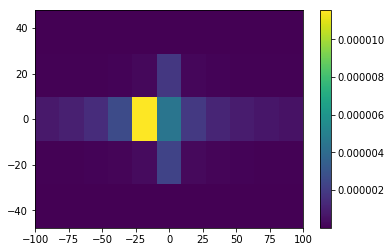

In [224]:
plt.imshow(np.abs(Cba_mvals),extent=((np.min(wvalsm)-p['freqmu']*2*pi)*1e-6,(np.max(wvalsm)-p['freqmu']*2*pi)*1e-6, np.min(Delvalsm)/2/pi*1e-6,np.max(Delvalsm)/2/pi*1e-6),aspect='auto')
plt.colorbar()
plt.savefig('cavity_detunea_2.pdf')

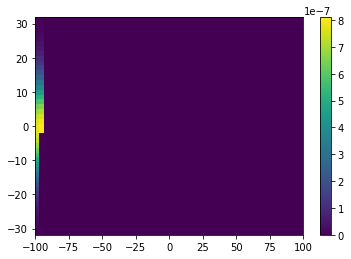

In [226]:
plt.imshow(np.abs(Cba_mvals),extent=((np.min(wvalsm)-p['freqmu']*2*pi)*1e-6,(np.max(wvalsm)-p['freqmu']*2*pi)*1e-6, np.min(Delvalsm)/2/pi*1e-6,np.max(Delvalsm)/2/pi*1e-6),aspect='auto')
plt.colorbar()

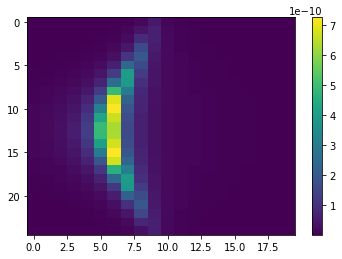

In [230]:

plt.imshow(np.abs(Cba_mvals[10:35,20:40])**2, aspect='auto')#,extent=((np.min(wvalsm)-p['freqmu']*2*pi)*1e-6,(np.max(wvalsm)-p['freqmu']*2*pi)*1e-6, np.min(Delvalsm)/2/pi*1e-6,np.max(Delvalsm)/2/pi*1e-6),aspect='auto')
plt.colorbar()